In [1]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time

import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)


from sl_inference_5Dinfer_hdf5.mock_generator import lens_model
from sl_inference_5Dinfer_hdf5.mock_generator.lens_properties import lens_properties
from sl_inference_5Dinfer_hdf5.mock_generator.lens_model import LensModel
from sl_inference_5Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens
# from sl_inference_4Dinfer_hdf5.aeta_mock_bank import open_bank
from sl_inference_5Dinfer_hdf5.mock_generator.mass_sampler import generate_samples, sample_m_s
from sl_inference_5Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation

In [4]:
sample = generate_samples(10000, model='deVauc',)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.gridspec import GridSpec

# # ---- 数据准备（df4 已包含数据） ----
# labels = ["logMstar", "logMh", "logRe", "gamma"]
# ndim = len(labels)
# data = sample

# # ---- 淡色配色设置（方案 B） ----
# color_scatter = "#A8DCEF"     # 浅蓝
# color_hist    = "#FFE6C2"     # 薄橙
# alpha_scatter = 0.1
# color_kde_68  = "#9EE490"     # 淡绿
# color_kde_95  = "#FDE9F2"     # 淡粉
# color_diag_kde= "#8989FA"     # 淡灰紫

# # ---- 图结构 ----



# fig = plt.figure(figsize=(9, 9))
# gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

# for i in range(ndim):
#     for j in range(ndim):
#         if j > i:
#             continue  # 只画下三角
#         ax = fig.add_subplot(gs[i, j])
#         x = data[:, j]

#         if i == j:
#             # 对角线
#             sns.histplot(x, bins=30, stat="density",
#                          color=color_hist, alpha=0.6, edgecolor=None, ax=ax)
#             sns.kdeplot(x=x, color=color_diag_kde, linewidth=1.6, ax=ax)
#             ax.set_ylabel("")
#             ax.set_yticks([])
#         else:
#             # 下三角
#             y = data[:, i]
#             ax.scatter(x, y, s=8, alpha=alpha_scatter,
#                        color=color_scatter, edgecolors="none")
#             sns.kdeplot(x=x, y=y,
#                         levels=[0.68, 0.95],
#                         colors=[color_kde_68, color_kde_95],
#                         linewidths=1.3, ax=ax)

#         # 坐标轴
#         if i < ndim - 1:
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel(labels[j])
#         if j > 0:
#             ax.set_yticklabels([])
#         else:
#             ax.set_ylabel(labels[i])

# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

samples = generate_samples(10000, model='deVauc')
alpha_s=-1.3
m_s_star=24.5
ms = sample_m_s(alpha_s, m_s_star, size=10000, rng=None, m_min=20.0, m_max=30.0)
df = pd.DataFrame(samples)

# 选取并重命名需要的五列
df4 = df[['logM_star_sps','logMh','logRe','gamma_in','logalpha']].rename(columns={
    'logM_star_sps': 'logM_star_sps',
    'logMh': 'logMh',
    'logRe': 'logRe',
    'gamma_in': 'gamma',
    'logalpha': 'logalpha'
})

# ✅ 在 logM_star_sps 后插入新列 logMstar
df4.insert(1, 'logMstar', df4['logM_star_sps'] + df4['logalpha'])
df4.insert(5, 'ms', ms)

# ---- 数据准备（df4 已包含数据） ----
labels = [
    r"$\log M_{sps}$",
    r"$\log M_{\star}$",
    r"$\log M_{\mathrm{h}}$",
    r"$\log R_{\mathrm{e}}$",
    r"$\gamma$",
    r"$m_{\mathrm{s}}$"
]

ndim = len(labels)
data = df4.values  # 转成 numpy

# ---- 淡色配色设置（方案 B） ----
color_scatter = "#1EC4F3"     # 浅蓝
color_hist    = "#FFD08D"     # 薄橙
alpha_scatter = 0.01
color_kde_68  = "#01B8F5"     # 淡绿
color_kde_95  = "#F687B3"     # 淡粉
color_diag_kde= "#92D8EB"     # 淡灰紫

# ---- 图结构 ----
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue  # 只画下三角
        ax = fig.add_subplot(gs[i, j])
        # ---- 添加minor ticks（次刻度）----
        ax.minorticks_on()  # 开启次刻度
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x = data[:, j]

        # ---- 计算 x 的 3σ 范围 ----
        x_mean, x_std = np.mean(x), np.std(x)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            # ---- 对角线 ----
            sns.histplot(x, bins=30, stat="density",
                         color=color_hist, alpha=0.9, edgecolor=None, ax=ax)
            # sns.kdeplot(x=x, color=color_diag_kde, linewidth=1.6, ax=ax)

            ax.set_xlim(x_min, x_max)  # ✅ 限制为 3σ 区间
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            # ---- 下三角 ----
            y = data[:, i]

            # 计算 y 的 3σ 范围
            y_mean, y_std = np.mean(y), np.std(y)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            ax.scatter(x, y, s=8, alpha=alpha_scatter,
                       color=color_scatter, edgecolors="none")
            sns.kdeplot(x=x, y=y,
                        levels=[0.68, 0.95],
                        colors=[color_kde_68, color_kde_95],
                        linewidths=1.3, ax=ax)

            # ✅ 设置坐标轴范围为 3σ
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

# ---- 坐标轴标签 ----
        # 处理 x 轴
        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])

        # 处理 y 轴（这里修复对角线也带标签的问题）
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])


        
# plt.savefig("figure1.png", dpi=100, bbox_inches='tight')

plt.show()


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_4199/1482597356.py:91: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=x, y=y,


In [ ]:
df4

,logM_star_sps,logMstar,logMh,logRe,gamma,ms,logalpha
0,11.360470,11.860470,12.720779,0.895437,1.028491,28.531605,0.5
1,11.345595,11.845595,12.827591,0.821402,0.926754,25.358525,0.5
2,11.420701,11.920701,14.165903,0.664316,0.801733,29.501027,0.5
3,11.317399,11.817399,13.235738,0.829643,1.129322,28.534464,0.5
4,11.215834,11.715834,12.969702,0.625010,0.947477,27.289814,0.5
...,...,...,...,...,...,...,...
9995,11.412611,11.912611,13.059074,0.753595,1.236058,26.854199,0.5
9996,11.329471,11.829471,12.840138,0.754732,0.970913,29.589011,0.5
9997,11.394222,11.894222,13.165757,0.745193,1.280198,26.495494,0.5
9998,11.463189,11.963189,13.124978,1.076357,0.899479,28.834948,0.5


In [4]:
np.max(df_lens["logMh5"])

415907916707.6144

In [2]:
df_lens, mock_lens_data, mock_observed_data, samples = run_mock_simulation(500000, nbkg=4e-4, process=10, if_source=True)

Processing lenses (process=10): 100%|██████████| 500000/500000 [02:04<00:00, 4007.78it/s]


In [3]:
np.max(mock_lens_data["m_s"]), np.min(mock_lens_data["m_s"])

(29.962597567584147, 22.60615935567426)

(array([ 1.,  1.,  0.,  0.,  1.,  1.,  4.,  2.,  2.,  2.,  3., 11., 11.,
         6.,  4., 14., 16., 10., 24., 20., 19., 23., 20., 34., 27., 38.,
        36., 38., 42., 43., 41., 42., 34., 49., 43., 48., 48., 43., 51.,
        40., 58., 46., 61., 37., 39., 56., 46., 54., 40., 39., 30., 38.,
        32., 34., 34., 26., 32., 28., 35., 26., 26., 24., 18., 20., 23.,
        18., 16., 16., 15., 10.,  9., 11., 13., 13., 11.,  9.,  7.,  6.,
         4.,  4.,  4.,  5.,  7.,  7.,  4.,  4.,  4.,  4.,  3.,  1.,  3.,
         0.,  2.,  2.,  2.,  2.,  0.,  1.,  0.,  1.]),
 array([ 9.42944741,  9.45208508,  9.47472274,  9.4973604 ,  9.51999807,
         9.54263573,  9.56527339,  9.58791106,  9.61054872,  9.63318638,
         9.65582405,  9.67846171,  9.70109937,  9.72373704,  9.7463747 ,
         9.76901236,  9.79165003,  9.81428769,  9.83692535,  9.85956302,
         9.88220068,  9.90483834,  9.92747601,  9.95011367,  9.97275133,
         9.995389  , 10.01802666, 10.04066432, 10.06330199, 10.085939

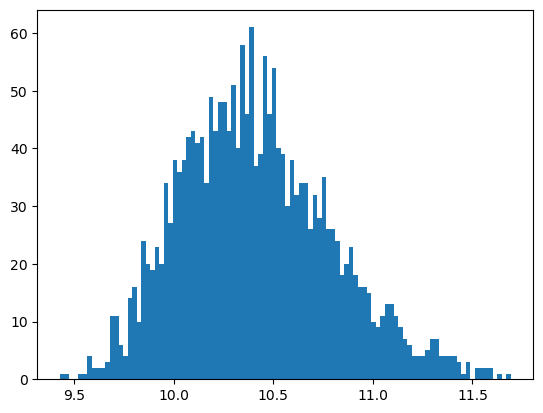

In [8]:
plt.hist(df_lens["logMh5"],bins=100)

In [3]:
df_lens.isna().sum()


xA                        49811
xB                        49811
beta                      49811
kappaA                    49811
kappaB                    49811
gammaA                    49811
gammaB                    49811
magnificationA            49811
magnificationB            49811
kappa_starA               49811
kappa_starB               49811
alphaA                    49811
alphaB                    49811
sA                        49811
sB                        49811
einstein_radius_kpc           0
einstein_radius_arcsec        0
scatter_mag               49811
magnitude_observedA       49811
magnitude_observedB       49811
is_lensed                     0
m_s                       49811
maximum_magnitude             0
beta_unit                 49811
logalpha_sps                  0
logM_star                     0
logM_star_sps                 0
logM_star_sps_observed    49811
logM_halo                     0
logRe                         0
zl                            0
zs      

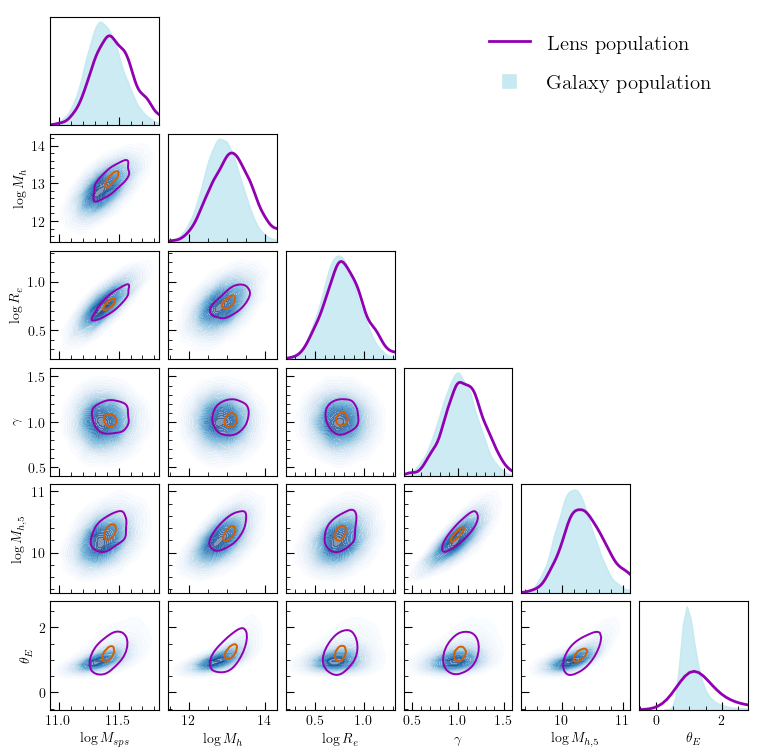

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D  # ✅ 用来做自定义legend

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

df = df_lens  # 全体 galaxy 数据

# ✅ 分成 总体 vs 强透镜 子集
df_all = df.copy()
df_lensed = df[df["is_lensed"] == True].copy()

# ✅ 对总体随机抽样 20000 条
if len(df_all) > 20000:
    df_all = df_all.sample(n=20000, random_state=42)

# 取需要的列
df4_all = df_all[['logM_star_sps','logM_halo','logRe','gamma_in', 'logMh5', 'einstein_radius_arcsec']]
df4_lens = df_lensed[['logM_star_sps','logM_halo','logRe','gamma_in', 'logMh5', 'einstein_radius_arcsec']]

labels = [
    r"$\log M_{sps}$",
    r"$\log M_{h}$",
    r"$\log R_{e}$",
    r"$\gamma$",
    r"$\log M_{h,5}$",
    r"$\theta_{E}$"
]

ndim = len(labels)

# ✅ 配色
color_kde_all = "#C7E9F1"
color_kde_lens_line = "#9100B2"
color_kde_68  = "#9100B2"
color_kde_95  = "#D55E00"

fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

data_all = df4_all.values
data_lens = df4_lens.values

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue
        ax = fig.add_subplot(gs[i, j])

        ax.minorticks_on()
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x_all = data_all[:, j]
        x_mean, x_std = np.mean(x_all), np.std(x_all)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            sns.kdeplot(x=x_all, fill=True, color=color_kde_all,
                        alpha=0.9, linewidth=1.2, ax=ax)

            if len(df4_lens) > 0:
                x_l = data_lens[:, j]
                sns.kdeplot(
                    x=x_l, color=color_kde_lens_line,
                    linewidth=2.0, ax=ax
                )

            ax.set_xlim(x_min, x_max)
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            y_all = data_all[:, i]
            y_mean, y_std = np.mean(y_all), np.std(y_all)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            if np.isnan(x_all).any() or np.isnan(y_all).any():
                print("NaN values found in data_all for indices:", i, j)

            sns.kdeplot(
                x=x_all, y=y_all,
                fill=True, thresh=0.05,
                cmap="Blues", alpha=0.5,
                levels=30,
                ax=ax,
            )

            if len(df4_lens) > 0:
                x_l = data_lens[:, j]
                y_l = data_lens[:, i]
                sns.kdeplot(
                    x=x_l, y=y_l,
                    levels=[0.68, 0.95],
                    colors=[color_kde_68, color_kde_95],
                    linewidths=1.4,
                    ax=ax
                )

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])

# ✅ 添加统一 legend
legend_elements = [
    Line2D([0], [0], color=color_kde_lens_line, lw=2, label="Lens population"),
    Line2D([0], [0], marker='s', color='w', label="Galaxy population",
           markerfacecolor=color_kde_all, markersize=12)
]
fig.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(0.9, 0.9),
    fontsize=15,          # 字体再大一点
    frameon=False,        # 去掉外框（更干净）
    borderpad=1.2,        # 内边距
    labelspacing=1.0      # 行距
)


plt.savefig("popdists1.png", dpi=600, bbox_inches='tight')
plt.show()


(array([7.99000e+02, 2.56300e+04, 1.05967e+05, 1.51167e+05, 1.15819e+05,
        6.03200e+04, 2.51660e+04, 9.35200e+03, 3.33100e+03, 1.25000e+03,
        4.95000e+02, 2.31000e+02, 1.36000e+02, 8.10000e+01, 6.20000e+01,
        3.00000e+01, 3.30000e+01, 3.10000e+01, 2.00000e+01, 1.60000e+01,
        4.00000e+00, 8.00000e+00, 1.10000e+01, 6.00000e+00, 4.00000e+00,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 3.00000e+00, 3.00000e+00,
        2.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

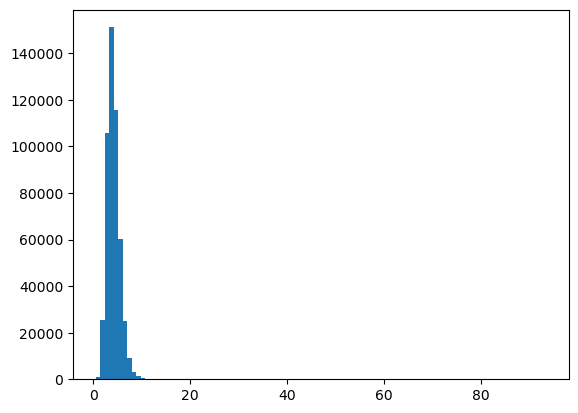

In [5]:
plt.hist(df_lens["ycaustic_kpc"],bins=100)

In [4]:
np.max(df_lens["ycaustic_kpc"])

93.4271664917387

In [3]:
df_lens

,xA,xB,beta,kappaA,kappaB,gammaA,gammaB,magnificationA,magnificationB,kappa_starA,...,c,ycaustic_kpc,ycaustic_arcsec,r200,rs,theta_E,gnfw_norm,sigma_crit,lens_id,is_lens
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.530003,1.465997,281.188998,56.237800,1.428876,2.192915e+11,2.352220e+09,0,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.079077,1.140262,291.324009,58.264802,1.245987,2.483201e+11,2.352220e+09,1,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.685242,1.276347,292.282120,58.456424,1.033323,3.402081e+11,2.352220e+09,2,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.148352,1.155814,586.218117,117.243623,1.356407,3.017584e+12,2.352220e+09,3,False
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.278128,1.184949,425.341200,85.068240,1.344170,9.407997e+11,2.352220e+09,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.100354,1.145039,341.585539,68.317108,1.400661,3.990346e+11,2.352220e+09,199931,False
199996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.316377,0.969034,675.144315,135.028863,1.277402,4.952947e+12,2.352220e+09,199932,False
199997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.781385,1.297931,351.528803,70.305761,1.007137,6.556719e+11,2.352220e+09,199933,False
199998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.990961,1.569483,595.194844,119.038969,1.981423,2.648048e+12,2.352220e+09,199934,False


In [3]:
mock_observed_data

,xA,xB,logM_star_sps_observed,logRe,magnitude_observedA,magnitude_observedB
217,11.125355,-10.120152,11.667360,0.791826,26.142427,26.313311
380,8.105343,-3.645874,11.316893,0.715315,23.151747,24.490355
474,12.291774,-3.640798,11.500231,0.831456,23.328447,24.525854
475,9.076078,-5.110776,11.490088,0.612574,25.721994,26.297911
690,4.608063,-3.903359,11.268010,0.482845,24.509514,24.640399
...,...,...,...,...,...,...
498572,10.141367,-7.770965,11.345135,0.785574,25.364151,25.493819
498665,9.531843,-2.200851,11.444211,1.020611,25.332942,26.471827
498840,8.091085,-4.418430,11.569994,0.743758,23.649758,24.307596
498864,10.356268,-3.372588,11.505557,0.722042,23.552983,24.888049


In [5]:
mu1, mu2 = mock_lens_data["magnificationA"], mock_lens_data["magnificationB"]

Text(0, 0.5, 'Number of Lenses')

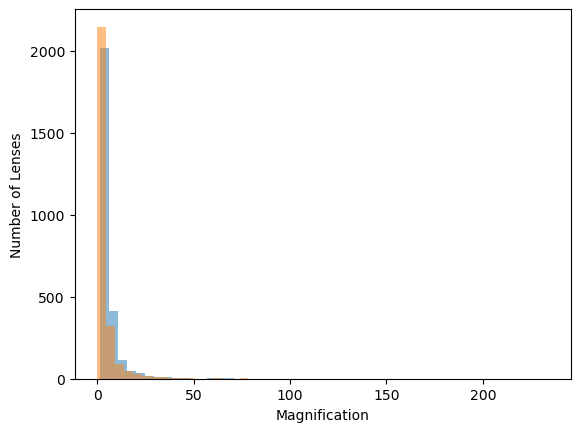

In [7]:
plt.hist(mu1, bins=50, alpha=0.5, label='mu1')
plt.hist(mu2, bins=50, alpha=0.5, label='mu2')
plt.xlabel('Magnification')
plt.ylabel('Number of Lenses')

In [8]:
np.min(mu1), np.max(mu1), np.min(mu2), np.max(mu2)

(1.364189175882485,
 233.91558153885452,
 0.059251131516493014,
 230.63577618361947)

In [11]:
from sl_inference_4Dinfer_hdf5.build_k_table import load_K_interpolator

# Preload K(mu1, mu2) interpolator (integrated over source magnitude with prior)
K_interp = load_K_interpolator(
    os.path.join("../K_K_table_mu1000_ms2000.h5"),
    method="linear",
    bounds_error=False,
    fill_value=0.0,
)


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_7973/3055705663.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(K_values), extent=(1e-4, 500.0, 1e-4, 500.0), origin='lower')


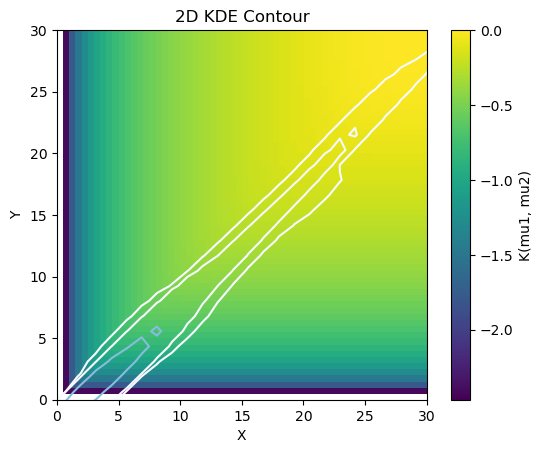

In [21]:
mulist = np.linspace(1e-4, 500.0, 1000)
Mu1, Mu2 = np.meshgrid(mulist, mulist, indexing='ij')
K_values = K_interp(Mu1.ravel(), Mu2.ravel()).reshape(Mu1.shape)

import matplotlib.pyplot as plt
plt.imshow(np.log(K_values), extent=(1e-4, 500.0, 1e-4, 500.0), origin='lower')
plt.colorbar(label='K(mu1, mu2)')
plt.xlabel('mu1')
plt.ylabel('mu2')

import matplotlib.pyplot as plt
import seaborn as sns


plt.xlim(0,30)
plt.ylim(0,30)
# 绘制KDE等高线
sns.kdeplot(x=mu1, y=mu2, fill=False, cmap="Blues", thresh=0.5, levels=[0.01, 0.05, 0.35, 1.0])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D KDE Contour")
plt.show()


In [4]:
from sl_inference_5Dinfer_hdf5.compute_A_eta import load_A_eta_interpolator


interp = load_A_eta_interpolator('../aeta_tables/Aeta5D_mu50_beta50_sigma50_mugamma50_alpha50.h5')


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_35963/4217626609.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_muDM_mugamma_grid[i,j] = interp(np.array([muDM, 2.04, 0.37, mugamma, 0]))


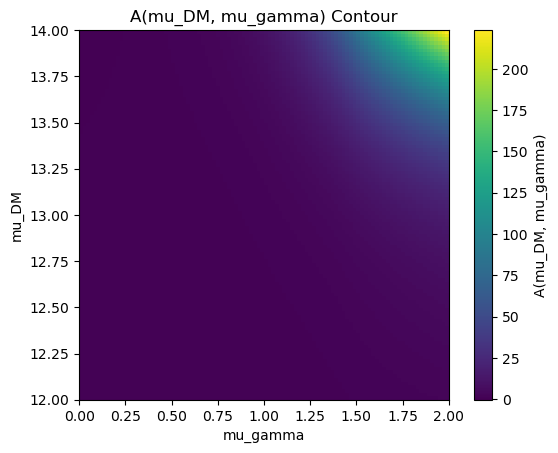

In [6]:
# A_muDM_mugamma_grid = [interp([muDM, 2.04, 0.37, mugamma, 0.2, 0]) for muDM in np.linspace(12,14,100) for mugamma in np.linspace(0,5,100)]

# A_muDM_mugamma_grid = [interp([muDM, 2.04, 0.37, mugamma, 0.2, 0]) for muDM in np.linspace(12,14,100) for mugamma in np.linspace(0,2,100)]
A_muDM_mugamma_grid = np.zeros((100,100))
for i, muDM in enumerate(np.linspace(12,14,100)):
    for j, mugamma in enumerate(np.linspace(0,2,100)):
        A_muDM_mugamma_grid[i,j] = interp(np.array([muDM, 2.04, 0.37, mugamma, 0]))


plt.imshow(A_muDM_mugamma_grid, extent=(0,2,12,14), origin='lower')
plt.colorbar(label='A(mu_DM, mu_gamma)')
plt.xlabel('mu_gamma')
plt.ylabel('mu_DM')
plt.title('A(mu_DM, mu_gamma) Contour')
plt.show()

/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_7973/2882461950.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_mugamma_sigmagama_grid[i,j] = interp(np.array([13.0, 2.04, 0.37, mugamma, sigmagamma, 0]))


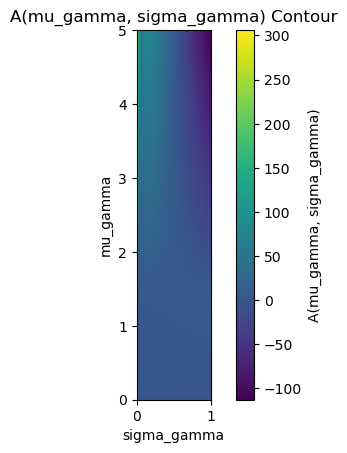

In [61]:
A_mugamma_sigmagama_grid = np.zeros((100,100))
for i, mugamma in enumerate(np.linspace(0,5,100)):
    for j, sigmagamma in enumerate(np.linspace(0,1,100)):
        A_mugamma_sigmagama_grid[i,j] = interp(np.array([13.0, 2.04, 0.37, mugamma, sigmagamma, 0]))

plt.imshow(A_mugamma_sigmagama_grid, extent=(0,1,0,5), origin='lower')
plt.colorbar(label='A(mu_gamma, sigma_gamma)')
plt.xlabel('sigma_gamma')
plt.ylabel('mu_gamma')
plt.title('A(mu_gamma, sigma_gamma) Contour')
plt.show()

/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_7973/2306410253.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_muDM_alpha_grid[i,j] = interp([muDM, 2.04, 0.37, 0.0, 0.2, alpha])
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_7973/2306410253.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_muDM_alpha_grid[i, j] = interp([muDM, 2.04, 0.37, 1, 0.2, alpha])


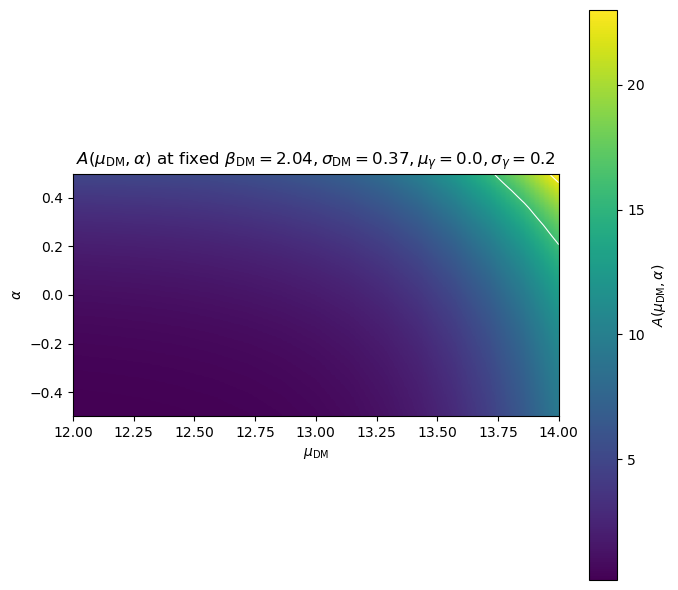

In [55]:
A_muDM_alpha_grid = np.zeros((100,100))
for i, muDM in enumerate(np.linspace(12,14,100)):
    for j, alpha in enumerate(np.linspace(-0.5,0.5,100)):
        A_muDM_alpha_grid[i,j] = interp([muDM, 2.04, 0.37, 0.0, 0.2, alpha])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 假设你已有 interp 对象
# A_muDM_alpha_grid[i, j] = interp([muDM, 2.04, 0.37, 0.0, 0.2, alpha])

# 生成网格
muDM_grid = np.linspace(12, 14, 100)
alpha_grid = np.linspace(-0.5, 0.5, 100)

# 构建二维切片
A_muDM_alpha_grid = np.zeros((len(muDM_grid), len(alpha_grid)))
for i, muDM in enumerate(muDM_grid):
    for j, alpha in enumerate(alpha_grid):
        A_muDM_alpha_grid[i, j] = interp([muDM, 2.04, 0.37, 1, 0.2, alpha])

# -----------------------------------------
# 绘图
# -----------------------------------------
plt.figure(figsize=(7, 6))

# 主图像（注意转置 + extent 对齐）
im = plt.imshow(
    A_muDM_alpha_grid.T,  # 让x→mu_DM, y→alpha
    origin='lower',
    extent=[muDM_grid.min(), muDM_grid.max(),
            alpha_grid.min(), alpha_grid.max()],
    aspect='equal',         # 保持1:1比例
    cmap='viridis'
)

# 添加颜色条
plt.colorbar(im, label=r"$A(\mu_{\rm DM}, \alpha)$")

# 添加等值线（例如68%、95%最大值）
levels = [0.68 * np.nanmax(A_muDM_alpha_grid),
          0.95 * np.nanmax(A_muDM_alpha_grid)]
plt.contour(
    muDM_grid,
    alpha_grid,
    A_muDM_alpha_grid.T,
    colors='white',
    levels=levels,
    linewidths=0.8
)

# 轴与标题
plt.xlabel(r"$\mu_{\rm DM}$")
plt.ylabel(r"$\alpha$")
plt.title(r"$A(\mu_{\rm DM}, \alpha)$ at fixed "
          r"$\beta_{\rm DM}=2.04, \sigma_{\rm DM}=0.37, \mu_\gamma=0.0, \sigma_\gamma=0.2$")
plt.tight_layout()
plt.show()



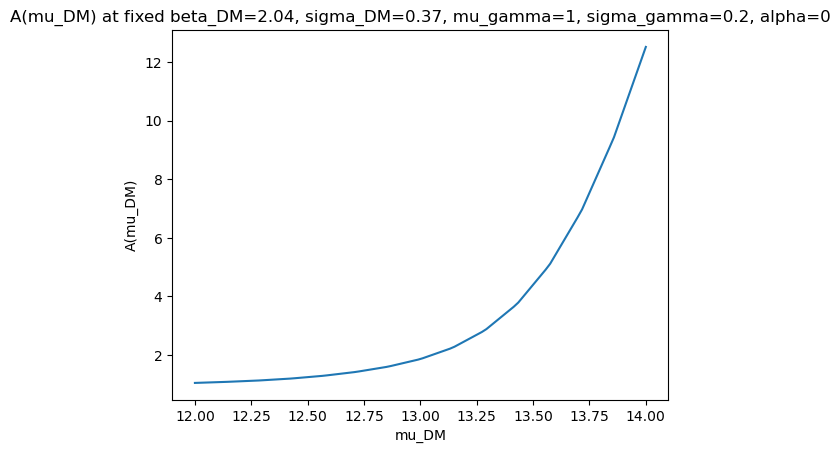

In [ ]:
muDM_grid = np.linspace(12, 14, 100)

A_muDM = [interp([muDM, 2.04, 0.37, 1, 0.2, 0]) for muDM in muDM_grid]

plt.plot(muDM_grid, A_muDM)
plt.xlabel('mu_DM')
plt.ylabel('A(mu_DM)')
plt.title('A(mu_DM) at fixed beta_DM=2.04, sigma_DM=0.37, mu_gamma=1, sigma_gamma=0.2, alpha=0')
plt.show()

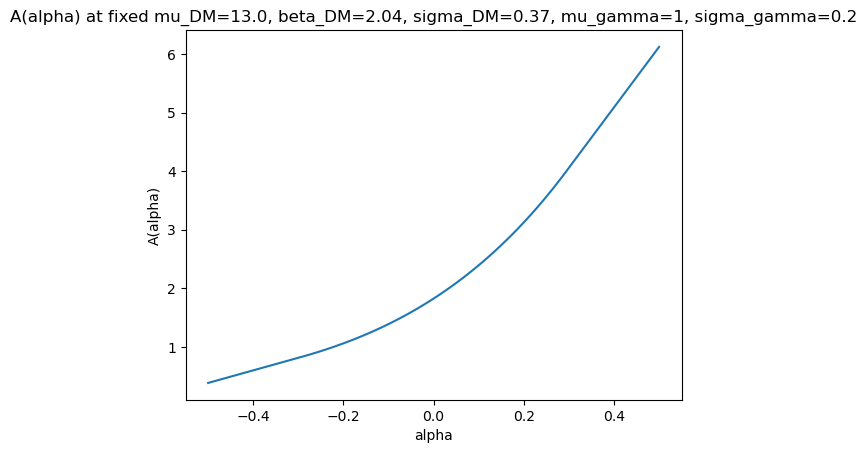

In [9]:
alphagrid = np.linspace(-0.5, 0.5, 100)

# A_muDM = [interp([muDM, 2.04, 0.37, 1, 0.2, 0]) for muDM in muDM_grid]
Aalpha = [interp([13.0, 2.04, 0.37, 1, alpha]) for alpha in alphagrid]

plt.plot(alphagrid, Aalpha)
plt.xlabel('alpha')
plt.ylabel('A(alpha)')
plt.title('A(alpha) at fixed mu_DM=13.0, beta_DM=2.04, sigma_DM=0.37, mu_gamma=1, sigma_gamma=0.2')
plt.show()

In [10]:
print(mock_observed_data.iloc[0])

xA                         5.644504
xB                        -3.957179
logM_star_sps_observed    11.400591
logRe                      0.985400
magnitude_observedA       25.403552
magnitude_observedB       25.591093
Name: 253, dtype: float64


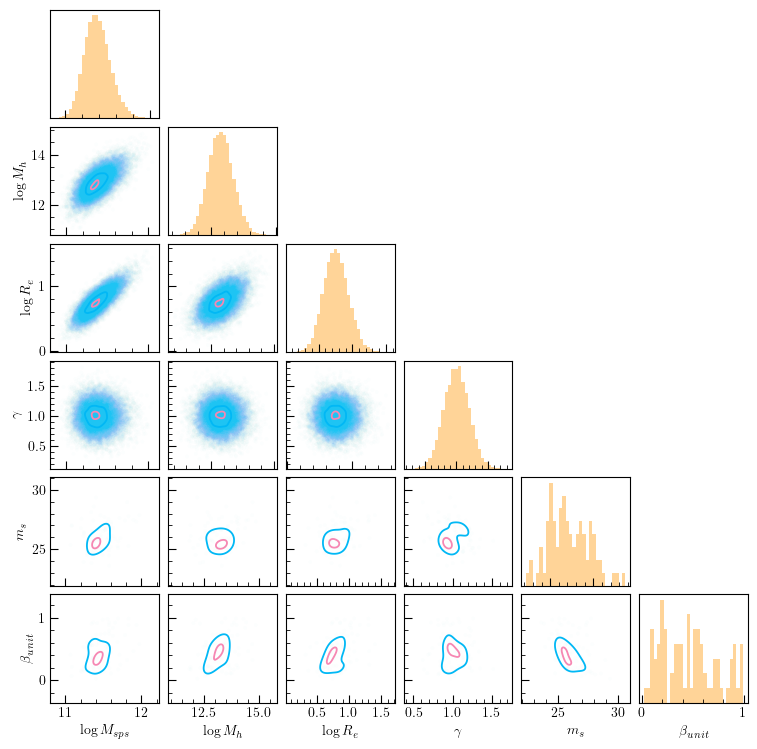

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

df = pd.DataFrame(samples)

# 选取并重命名需要的五列
df4 = df[['logM_star_sps','logMh','logRe','gamma_in','m_s','beta_unit']].rename(columns={
    'logM_star_sps': 'logM_star_sps',
    'logMh': 'logMh',
    'logRe': 'logRe',
    'gamma_in': 'gamma',
    'm_s': 'm_s',
    'beta_unit': 'beta_unit'
})


# ---- 数据准备（df4 已包含数据） ----
labels = [
    r"$\log M_{sps}$",
    r"$\log M_{h}$",
    r"$\log R_{e}$",
    r"$\gamma$",
    r"$m_{s}$",
    r"$\beta_{unit}$"
]

ndim = len(labels)
data = df4.values  # 转成 numpy

# ---- 淡色配色设置（方案 B） ----
color_scatter = "#1EC4F3"     # 浅蓝
color_hist    = "#FFD08D"     # 薄橙
alpha_scatter = 0.01
color_kde_68  = "#01B8F5"     # 淡绿
color_kde_95  = "#F687B3"     # 淡粉
color_diag_kde= "#92D8EB"     # 淡灰紫

# ---- 图结构 ----
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue  # 只画下三角
        ax = fig.add_subplot(gs[i, j])
        # ---- 添加minor ticks（次刻度）----
        ax.minorticks_on()  # 开启次刻度
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x = data[:, j]

        # ---- 计算 x 的 3σ 范围 ----
        x_mean, x_std = np.mean(x), np.std(x)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            # ---- 对角线 ----
            sns.histplot(x, bins=30, stat="density",
                         color=color_hist, alpha=0.9, edgecolor=None, ax=ax)
            # sns.kdeplot(x=x, color=color_diag_kde, linewidth=1.6, ax=ax)

            # ax.set_xlim(x_min, x_max)  # ✅ 限制为 3σ 区间
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            # ---- 下三角 ----
            y = data[:, i]

            # 计算 y 的 3σ 范围
            y_mean, y_std = np.mean(y), np.std(y)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            ax.scatter(x, y, s=8, alpha=alpha_scatter,
                       color=color_scatter, edgecolors="none")
            sns.kdeplot(x=x, y=y,
                        levels=[0.68, 0.95],
                        colors=[color_kde_68, color_kde_95],
                        linewidths=1.3, ax=ax)

            # ✅ 设置坐标轴范围为 3σ
            # ax.set_xlim(x_min, x_max)
            # ax.set_ylim(y_min, y_max)

# ---- 坐标轴标签 ----
        # 处理 x 轴
        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])

        # 处理 y 轴（这里修复对角线也带标签的问题）
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])


        
# plt.savefig("figure1.png", dpi=100, bbox_inches='tight')

plt.show()


In [6]:
df_lens

,xA,xB,beta,kappaA,kappaB,gammaA,gammaB,magnificationA,magnificationB,kappa_starA,...,logM_star_sps_observed,logM_halo,logRe,zl,zs,ycaustic_kpc,ycaustic_arcsec,lens_id,is_lens,gamma_in
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.571932,0.870255,0.3,2.0,3.697507,0.830097,0,False,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.873166,0.791925,0.3,2.0,4.190500,0.940775,2,False,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.246907,0.895801,0.3,2.0,3.342183,0.750326,4,False,NaN
3,9.953887,-3.223781,0.651585,0.323829,1.017009,0.325624,1.067872,2.846516,0.880275,0.099055,...,11.564483,13.434334,0.938512,0.3,2.0,5.358158,1.202916,1,True,1.045616
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.536660,0.873270,0.3,2.0,4.257016,0.955708,5,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.877259,1.052427,0.3,2.0,6.819229,1.530929,19996,False,NaN
19996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.796259,0.906322,0.3,2.0,3.591794,0.806364,19997,False,NaN
19997,5.335281,-2.576102,0.357640,0.169271,0.576538,0.462098,1.187686,2.097811,0.812972,0.121122,...,11.113108,12.273500,0.502701,0.3,2.0,5.501042,1.234994,19993,True,0.951917
19998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.826665,1.062563,0.3,2.0,5.104563,1.145984,19998,False,NaN


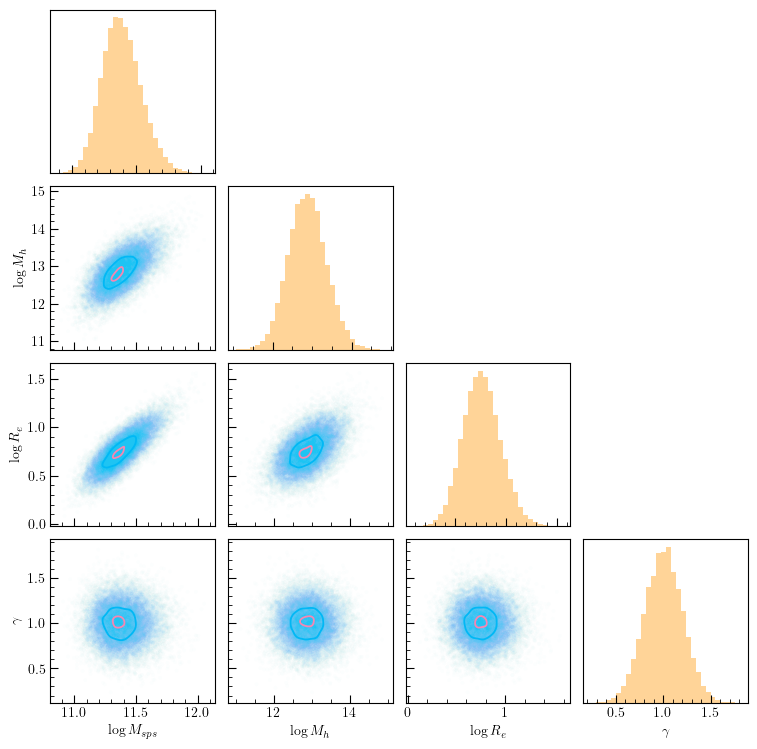

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

df = df_lens

# 选取并重命名需要的五列
df4 = df[['logM_star_sps','logM_halo','logRe','gamma_in']].rename(columns={
    'logM_star_sps': 'logM_star_sps',
    'log_halo': 'log_halo',
    'logRe': 'logRe',
    'gamma_in': 'gamma',
})


# ---- 数据准备（df4 已包含数据） ----
labels = [
    r"$\log M_{sps}$",
    r"$\log M_{h}$",
    r"$\log R_{e}$",
    r"$\gamma$",
]

ndim = len(labels)
data = df4.values  # 转成 numpy

# ---- 淡色配色设置（方案 B） ----
color_scatter = "#1EC4F3"     # 浅蓝
color_hist    = "#FFD08D"     # 薄橙
alpha_scatter = 0.01
color_kde_68  = "#01B8F5"     # 淡绿
color_kde_95  = "#F687B3"     # 淡粉
color_diag_kde= "#92D8EB"     # 淡灰紫

# ---- 图结构 ----
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue  # 只画下三角
        ax = fig.add_subplot(gs[i, j])
        # ---- 添加minor ticks（次刻度）----
        ax.minorticks_on()  # 开启次刻度
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x = data[:, j]

        # ---- 计算 x 的 3σ 范围 ----
        x_mean, x_std = np.mean(x), np.std(x)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            # ---- 对角线 ----
            sns.histplot(x, bins=30, stat="density",
                         color=color_hist, alpha=0.9, edgecolor=None, ax=ax)
            # sns.kdeplot(x=x, color=color_diag_kde, linewidth=1.6, ax=ax)

            # ax.set_xlim(x_min, x_max)  # ✅ 限制为 3σ 区间
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            # ---- 下三角 ----
            y = data[:, i]

            # 计算 y 的 3σ 范围
            y_mean, y_std = np.mean(y), np.std(y)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            ax.scatter(x, y, s=8, alpha=alpha_scatter,
                       color=color_scatter, edgecolors="none")
            sns.kdeplot(x=x, y=y,
                        levels=[0.68, 0.95],
                        colors=[color_kde_68, color_kde_95],
                        linewidths=1.3, ax=ax)

            # ✅ 设置坐标轴范围为 3σ
            # ax.set_xlim(x_min, x_max)
            # ax.set_ylim(y_min, y_max)

# ---- 坐标轴标签 ----
        # 处理 x 轴
        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])

        # 处理 y 轴（这里修复对角线也带标签的问题）
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])


        
# plt.savefig("figure1.png", dpi=100, bbox_inches='tight')

plt.show()


In [6]:
df_lens.columns

Index(['xA', 'xB', 'beta', 'kappaA', 'kappaB', 'gammaA', 'gammaB',
       'magnificationA', 'magnificationB', 'kappa_starA', 'kappa_starB',
       'alphaA', 'alphaB', 'sA', 'sB', 'einstein_radius_kpc',
       'einstein_radius_arcsec', 'scatter_mag', 'magnitude_observedA',
       'magnitude_observedB', 'is_lensed', 'm_s', 'maximum_magnitude',
       'beta_unit', 'logalpha_sps', 'logM_star', 'logM_star_sps',
       'logM_star_sps_observed', 'logM_halo', 'logRe', 'zl', 'zs', 'gamma_in',
       'c', 'ycaustic_kpc', 'ycaustic_arcsec', 'r200', 'rs', 'theta_E',
       'gnfw_norm', 'sigma_crit', 'lens_id', 'is_lens'],
      dtype='object')

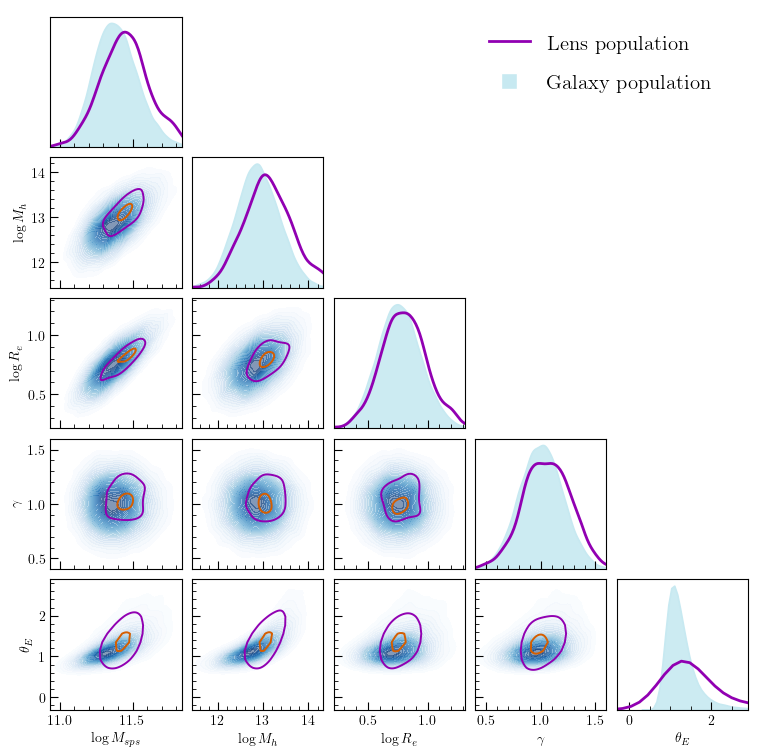

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D  # ✅ 用来做自定义legend

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

df = df_lens  # 全体 galaxy 数据

# ✅ 分成 总体 vs 强透镜 子集
df_all = df.copy()
df_lensed = df[df["is_lensed"] == True].copy()

# ✅ 对总体随机抽样 20000 条
if len(df_all) > 20000:
    df_all = df_all.sample(n=20000, random_state=42)

# 取需要的列
df4_all = df_all[['logM_star_sps','logM_halo','logRe','gamma_in', 'einstein_radius_arcsec']]
df4_lens = df_lensed[['logM_star_sps','logM_halo','logRe','gamma_in', 'einstein_radius_arcsec']]

labels = [
    r"$\log M_{sps}$",
    r"$\log M_{h}$",
    r"$\log R_{e}$",
    r"$\gamma$",
    r"$\theta_{E}$"
]

ndim = len(labels)

# ✅ 配色
color_kde_all = "#C7E9F1"
color_kde_lens_line = "#9100B2"
color_kde_68  = "#9100B2"
color_kde_95  = "#D55E00"

fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

data_all = df4_all.values
data_lens = df4_lens.values

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue
        ax = fig.add_subplot(gs[i, j])

        ax.minorticks_on()
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x_all = data_all[:, j]
        x_mean, x_std = np.mean(x_all), np.std(x_all)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            sns.kdeplot(x=x_all, fill=True, color=color_kde_all,
                        alpha=0.9, linewidth=1.2, ax=ax)

            if len(df4_lens) > 0:
                x_l = data_lens[:, j]
                sns.kdeplot(
                    x=x_l, color=color_kde_lens_line,
                    linewidth=2.0, ax=ax
                )

            ax.set_xlim(x_min, x_max)
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            y_all = data_all[:, i]
            y_mean, y_std = np.mean(y_all), np.std(y_all)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            sns.kdeplot(
                x=x_all, y=y_all,
                fill=True, thresh=0.05,
                cmap="Blues", alpha=0.5,
                levels=30,
                ax=ax,
            )

            if len(df4_lens) > 0:
                x_l = data_lens[:, j]
                y_l = data_lens[:, i]
                sns.kdeplot(
                    x=x_l, y=y_l,
                    levels=[0.68, 0.95],
                    colors=[color_kde_68, color_kde_95],
                    linewidths=1.4,
                    ax=ax
                )

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])

# ✅ 添加统一 legend
legend_elements = [
    Line2D([0], [0], color=color_kde_lens_line, lw=2, label="Lens population"),
    Line2D([0], [0], marker='s', color='w', label="Galaxy population",
           markerfacecolor=color_kde_all, markersize=12)
]
fig.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(0.9, 0.9),
    fontsize=15,          # 字体再大一点
    frameon=False,        # 去掉外框（更干净）
    borderpad=1.2,        # 内边距
    labelspacing=1.0      # 行距
)


plt.savefig("popdists.png", dpi=600, bbox_inches='tight')
plt.show()


In [10]:
# df4_all = df_all[['logM_star_sps','logM_halo','logRe','gamma_in', 'einstein_radius_arcsec']]
# df4_lens = df_lensed[['logM_star_sps','logM_halo','logRe','gamma_in', 'einstein_radius_arcsec']]

df4_all.describe()

,logM_star_sps,logM_halo,logRe,gamma_in,einstein_radius_arcsec
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,11.385920,12.877448,0.761806,1.000585,1.291096
std,0.150198,0.481817,0.183575,0.199323,0.532157
min,10.876272,11.065475,0.090488,0.197240,0.517712
25%,11.281236,12.554552,0.636823,0.865712,1.008230
50%,11.378523,12.869597,0.758000,1.001456,1.172892
75%,11.481796,13.198047,0.882253,1.135078,1.408320
max,12.041823,14.694509,1.578676,1.844879,14.498925


In [12]:
df4_lens.describe()

,logM_star_sps,logM_halo,logRe,gamma_in,einstein_radius_arcsec
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,11.453030,13.132035,0.806567,1.059324,1.868255
std,0.167141,0.550236,0.192726,0.214642,1.908820
min,10.985330,11.409297,0.171833,0.301360,0.650756
25%,11.340445,12.763263,0.680926,0.906692,1.140722
50%,11.448338,13.101265,0.802330,1.058882,1.386387
75%,11.552606,13.475014,0.930359,1.209699,1.817786
max,12.047271,15.298357,1.480568,1.729111,38.471391


In [1]:
import sys
sys.path.append("../../")  # 根据你的 notebook 路径设置

from sl_inference_4Dinfer_hdf5.mock_generator.lens_model import LensModel
from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens, solve_lens_parameters_from_obs_yc


model = LensModel(logM_star=11.5, logM_halo=13.0, c=5, logRe=0.8,gamma_in=1, zl=0.3, zs=2.0)
xA, xB = solve_single_lens(model,0.5)
xA, xB

# def solve_lens_parameters_from_obs_yc(xA_obs, xB_obs, logRe_obs, logM_halo, zl, zs, gamma_in: float = 1.0, c=None):
Mstar, beta,yc = solve_lens_parameters_from_obs_yc(xA, xB, 0.8, 13, 0.3, 2,gamma_in=1)
print(Mstar, beta, yc)

11.5 0.5000000000000002 4.254562286748494


In [1]:
import sys
sys.path.append("../../")  # 根据你的 notebook 路径设置

from sl_inference_4Dinfer_hdf5.mock_generator.lens_model import LensModel
from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens, solve_lens_parameters_from_obs_yc


model = LensModel(logM_star=12.5, logM_halo=13.5, c=5, logRe=0.8,gamma_in=1, zl=0.3, zs=2.0)
xA, xB = solve_single_lens(model,0.8)
xA, xB

# def solve_lens_parameters_from_obs_yc(xA_obs, xB_obs, logRe_obs, logM_halo, zl, zs, gamma_in: float = 1.0, c=None):
Mstar, beta,yc = solve_lens_parameters_from_obs_yc(xA, xB, 0.8, 13, 0.3, 2,gamma_in=1)
print(Mstar, beta, yc)

12.5 0.8 49.126924774593526


In [ ]:
import h5py

# 打开 HDF5 文件（只读）
with h5py.File("../bank_uniform.h5", "r") as f:
    # 查看顶层 keys
    print("Top-level keys:", list(f.keys()))

    # 进入 base 组
    base = f["base"]
    print("base keys:", list(base.keys()))

    # 进入 lens 组
    lens = f["lens"]
    print("lens keys:", list(lens.keys()))

    # 读取具体数据，比如 logMh 和 mu1
    logMh = base["logMh"][:]      # numpy 数组
    mu1   = lens["mu1"][:]

print("logMh shape:", logMh.shape)
print("mu1 shape:", mu1.shape)
print("example logMh[0:5] =", logMh[:5])


Top-level keys: ['base', 'lens', 'select', 'weights']
base keys: ['beta', 'id', 'logM_star', 'logMh', 'logRe', 'ms', 'zl', 'zs']
lens keys: ['betamax', 'detJ', 'mu1', 'mu2', 'ok_mask']
logMh shape: (160000,)
mu1 shape: (160000,)
example logMh[0:5] = [10.203599 13.129704 17.274073 12.97789  10.181429]


In [ ]:

# 1. 打开 HDF5 文件
bank_path = "../bank_uniform.h5"  # 换成你生成的文件名
bank = open_bank(bank_path)

# 2. 读取数据到内存
logMh = bank["logMh"][...]      # halo mass
print(np.shape(logMh))

(160000,)


In [ ]:

# 1. 打开 HDF5 文件
bank_path = "../../bank.part000.h5"  # 换成你生成的文件名
bank = open_bank(bank_path)

# 2. 读取数据到内存
logMh = bank["logMh"][...]      # halo mass
logMstar = bank["logM_star"][...]
logRe = bank["logRe"][...]
beta = bank["beta"][...]
mu1 = bank["mu1"][...]
mu2 = bank["mu2"][...]
detJ = bank["detJ"][...]
betamax = bank["betamax"][...]
ok_mask = bank["ok_mask"][...]

betaunit = beta / betamax

# 3. 随机抽取 10000 个索引
N = len(logMh)

idx = np.random.default_rng(seed=42).choice(N, size=1000000, replace=False)

sample_logMh = logMh[idx]
sample_logMstar = logMstar[idx]
sample_mu1 = mu1[idx]
sample_mu2 = mu2[idx]

# 4. 做统计
print("logMh  mean/std:", np.nanmean(sample_logMh), np.nanstd(sample_logMh))
print("logM*  mean/std:", np.nanmean(sample_logMstar), np.nanstd(sample_logMstar))
print("μ1     mean/std:", np.nanmean(sample_mu1), np.nanstd(sample_mu1))
print("μ2     mean/std:", np.nanmean(sample_mu2), np.nanstd(sample_mu2))
print("有效样本占比:", np.count_nonzero(ok_mask[idx]) / len(idx))


ValueError: a must be a positive integer unless no samples are taken

In [ ]:
plt.hist(sample_logMstar, bins=50, alpha=0.5, label='logM*')
plt.hist(sample_logMh, bins=50, alpha=0.5, label='logMh')
plt.xlabel('Value')
plt.ylabel('Frequency')

NameError: name 'sample_logMstar' is not defined

NameError: name 'sample_logMh' is not defined

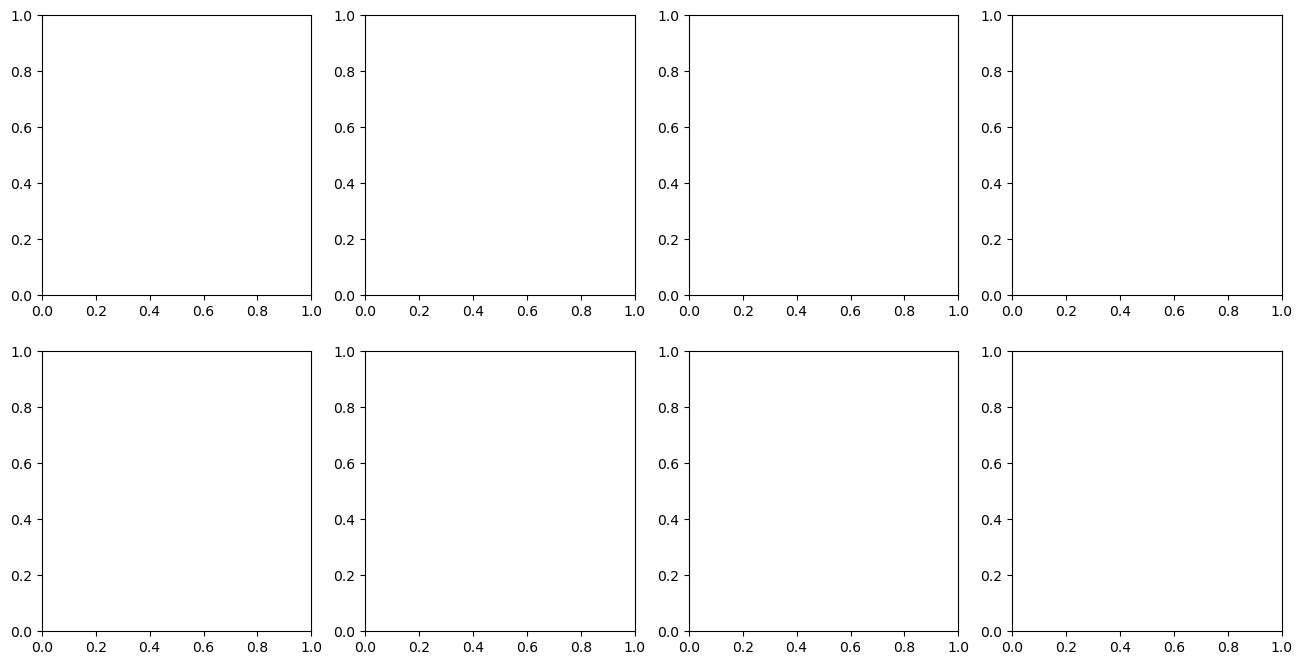

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

axes[0].hist(sample_logMh, bins=100, color='blue', alpha=0.7)
axes[0].set_title('logMh Distribution')

axes[1].hist(sample_logMstar, bins=100, color='green', alpha=0.7)
axes[1].set_title('logM* Distribution')

# 只把 range(...) 换成 linspace(0, 30, 100)
axes[2].hist(sample_mu1, bins=np.linspace(0, 30, 100), color='orange', alpha=0.7)
axes[2].set_title('μ1 Distribution')

axes[3].hist(sample_mu2, bins=np.linspace(0, 30, 100), color='red', alpha=0.7)
axes[3].set_title('μ2 Distribution')

axes[4].hist(betaunit[idx], bins=100, color='purple', alpha=0.7)
axes[4].set_title('betaunit Distribution')

axes[5].hist(logRe[idx], bins=100, color='brown', alpha=0.7)
axes[5].set_title('logRe Distribution')

axes[6].hist(betamax[idx], bins=np.linspace(0, 30, 100), color='cyan', alpha=0.7)
axes[6].set_title('betamax Distribution')

axes[7].hist(detJ[idx], bins=np.linspace(0, 0.3, 100), color='magenta', alpha=0.7)
axes[7].set_title('detJ Distribution')

plt.tight_layout()
plt.show()


In [ ]:
np.nanmax(mu1), np.nanmax(mu2)

(48926652.0, 48926652.0)

In [ ]:
# 95 分位
np.nanpercentile(mu1, 95), np.nanpercentile(mu2, 95)

(26.289233875274654, 24.047515487670864)

In [ ]:
# 99
np.nanpercentile(mu1, 99), np.nanpercentile(mu2, 99)

(126.86465133667019, 124.65714675903354)

In [ ]:
# 99.5
np.nanpercentile(mu1, 99.5), np.nanpercentile(mu2, 99.5)

(252.50418205260422, 250.39179893492934)

In [ ]:
import h5py
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

# from sl_inference_4Dinfer_hdf5.mock_generator import lens_model
# from sl_inference_4Dinfer_hdf5.mock_generator.lens_properties import lens_properties
# from sl_inference_4Dinfer_hdf5.mock_generator.lens_model import LensModel
# from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation

In [ ]:
100000/1000


100.0

In [ ]:
df_lens, mock_lens_data, mock_observed_data, samples = run_mock_simulation(100000, process=10, if_source=True, nbkg=1e-3)

Processing lenses (process=10): 100%|██████████| 10000/10000 [00:04<00:00, 2278.31it/s]


In [ ]:
df_lens, mock_lens_data, mock_observed_data, samples, N_i_array = run_mock_simulation(100000, nbkg=1e-3, process=8, if_source=True, return_N_i=True)

Processing lenses (process=8):  12%|█▏        | 12390/100000 [02:02<14:38, 99.77it/s] Process SpawnPoolWorker-22:
Process SpawnPoolWorker-25:
Process SpawnPoolWorker-26:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-21:
Process SpawnPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/qu

EOFError: Ran out of input

In [ ]:
mock_observed_data

,xA,xB,logM_star_sps_observed,logRe,magnitude_observedA,magnitude_observedB
20,11.070720,-3.556592,11.361186,0.969201,23.329614,24.204314
23,13.594667,-3.642594,11.689497,0.737365,23.032778,24.644680
25,4.354060,-3.850734,11.358148,0.672020,26.280986,26.453638
28,22.020567,-16.221177,11.663782,0.944339,22.386407,22.765996
35,5.409320,-4.243235,11.349792,0.702606,25.533055,25.828743
...,...,...,...,...,...,...
845,13.298168,-2.354110,11.605390,0.827231,24.551759,26.337342
847,7.931242,-2.081677,11.367845,0.747730,24.099438,25.731411
852,13.664183,-1.563465,11.520400,0.912251,24.113809,26.062305
856,6.341317,-5.666781,11.668337,0.821707,21.856577,21.846588


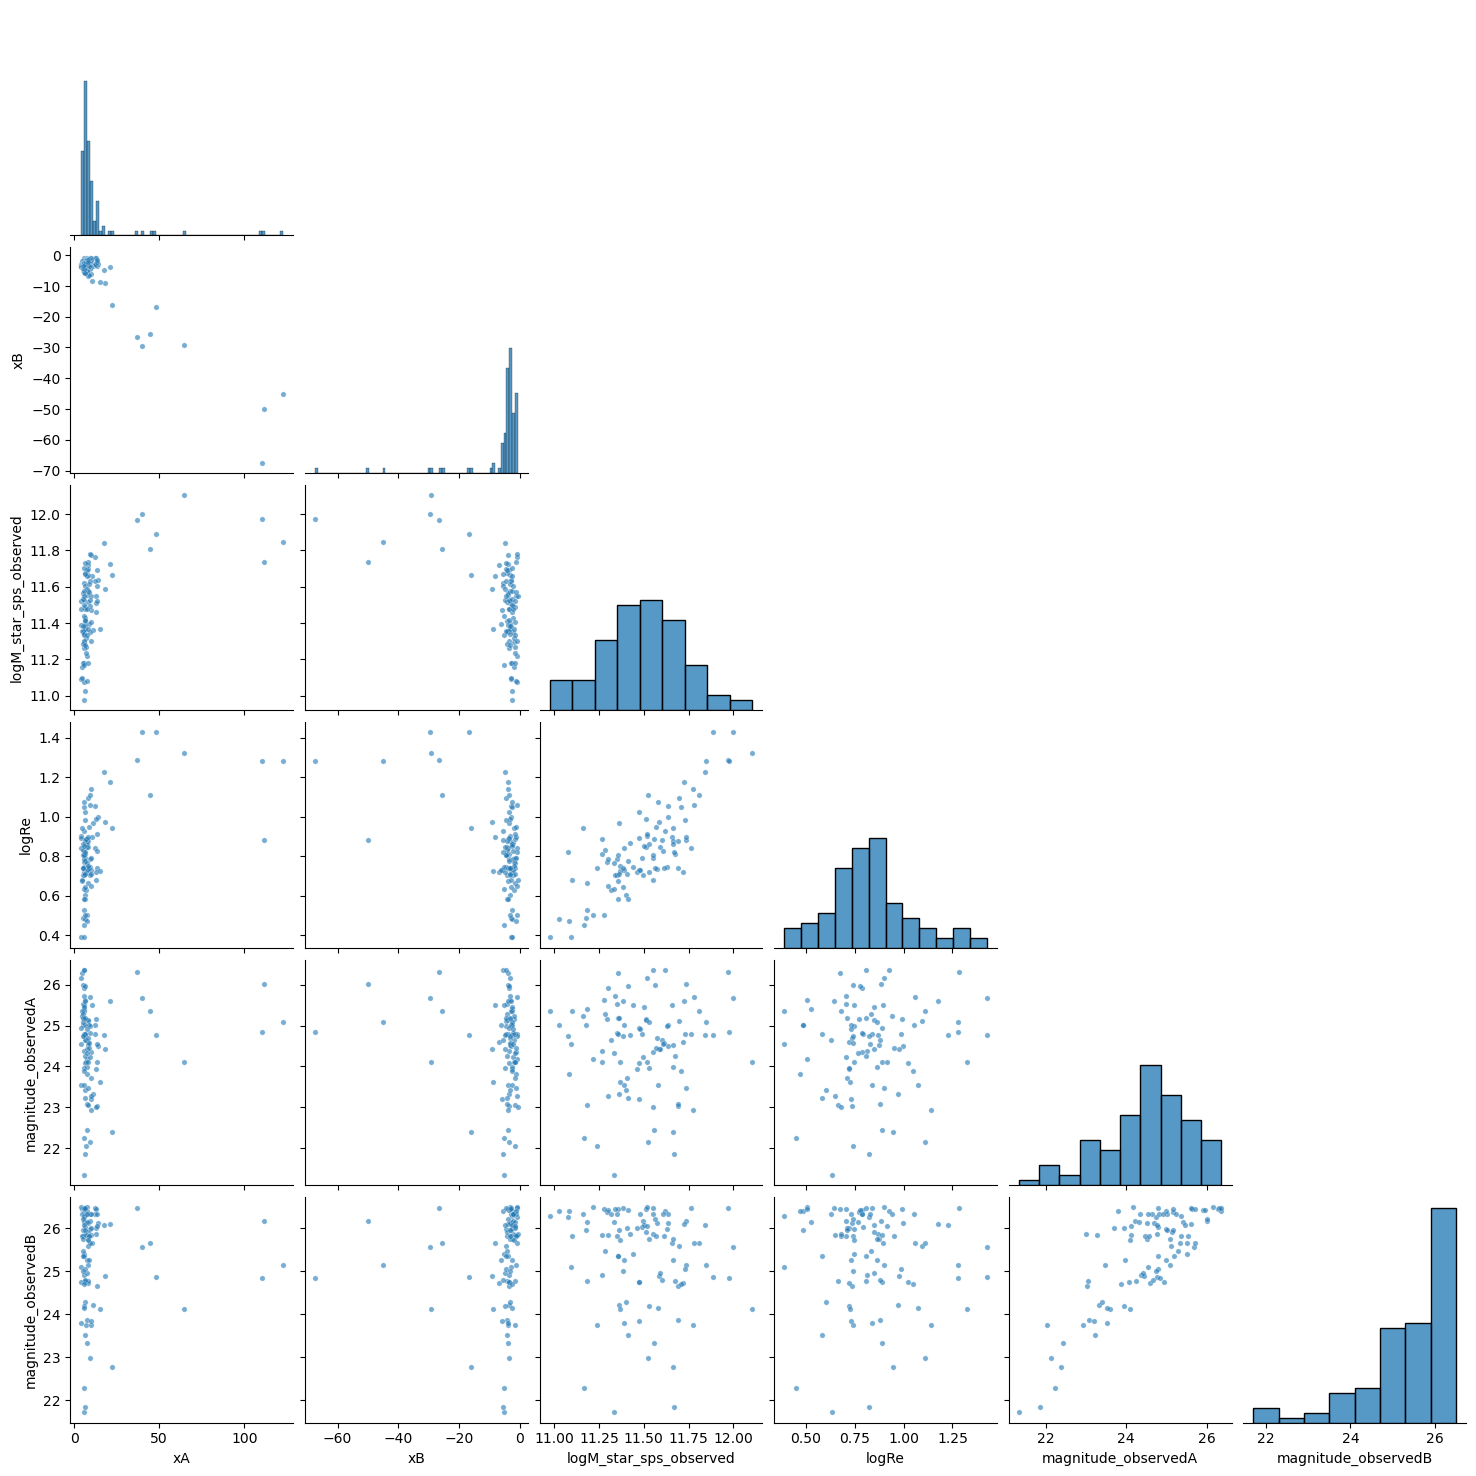

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
# ---- 全局美化：论文风 ----
# plt.rcParams.update({
#     "font.family": "serif",
#     "mathtext.fontset": "dejavuserif",
#     "axes.linewidth": 0.8,         # 坐标轴线宽
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "xtick.major.size": 4,
#     "ytick.major.size": 4,
#     "xtick.minor.size": 2,
#     "ytick.minor.size": 2,
#     "xtick.major.width": 0.8,
#     "ytick.major.width": 0.8,
#     "xtick.minor.width": 0.6,
#     "ytick.minor.width": 0.6,
#     "xtick.minor.visible": True,
#     "ytick.minor.visible": True,
# })

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

df4 = mock_observed_data

# ---- 数据准备（df4 已包含数据） ----
labels = [
    r"$\log M_{sps}$",
    r"$\log M_{\star}$",
    r"$\log M_{\mathrm{h}}$",
    r"$\log R_{\mathrm{e}}$",
    r"$\gamma$",
    r"$m_{\mathrm{s}}$"
]

ndim = len(labels)
data = df4.values  # 转成 numpy

# ---- 淡色配色设置（方案 B） ----
color_scatter = "#1EC4F3"     # 浅蓝
color_hist    = "#FFD08D"     # 薄橙
alpha_scatter = 0.01
color_kde_68  = "#01B8F5"     # 淡绿
color_kde_95  = "#F687B3"     # 淡粉
color_diag_kde= "#92D8EB"     # 淡灰紫

# ---- 图结构 ----
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(ndim, ndim, wspace=0.08, hspace=0.08)

for i in range(ndim):
    for j in range(ndim):
        if j > i:
            continue  # 只画下三角
        ax = fig.add_subplot(gs[i, j])
        # ---- 添加minor ticks（次刻度）----
        ax.minorticks_on()  # 开启次刻度
        ax.tick_params(axis="both", which="major", direction="in", length=6, width=0.8)
        ax.tick_params(axis="both", which="minor", direction="in", length=3, width=0.6)

        x = data[:, j]

        # ---- 计算 x 的 3σ 范围 ----
        x_mean, x_std = np.mean(x), np.std(x)
        x_min, x_max = x_mean - 3 * x_std, x_mean + 3 * x_std

        if i == j:
            # ---- 对角线 ----
            sns.histplot(x, bins=30, stat="density",
                         color=color_hist, alpha=0.9, edgecolor=None, ax=ax)
            # sns.kdeplot(x=x, color=color_diag_kde, linewidth=1.6, ax=ax)

            ax.set_xlim(x_min, x_max)  # ✅ 限制为 3σ 区间
            ax.set_ylabel("")
            ax.set_yticks([])

        else:
            # ---- 下三角 ----
            y = data[:, i]

            # 计算 y 的 3σ 范围
            y_mean, y_std = np.mean(y), np.std(y)
            y_min, y_max = y_mean - 3 * y_std, y_mean + 3 * y_std

            ax.scatter(x, y, s=8, alpha=alpha_scatter,
                       color=color_scatter, edgecolors="none")
            sns.kdeplot(x=x, y=y,
                        levels=[0.68, 0.95],
                        colors=[color_kde_68, color_kde_95],
                        linewidths=1.3, ax=ax)

            # ✅ 设置坐标轴范围为 3σ
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

# ---- 坐标轴标签 ----
        # 处理 x 轴
        if i < ndim - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(labels[j])

        # 处理 y 轴（这里修复对角线也带标签的问题）
        if j > 0 or i == j:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.set_ylabel(labels[i])


        
plt.savefig("figure.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
mock_lens_data

,xA,xB,beta,kappaA,kappaB,gammaA,gammaB,magnificationA,magnificationB,kappa_starA,...,logM_star,logM_star_sps,logM_star_sps_observed,logM_halo,logRe,zl,zs,lens_id,ycaustic_kpc,ycaustic_arcsec
3,6.757260,-4.668586,0.214281,0.299676,0.494426,0.507794,0.784918,4.295643,2.778838,0.185760,...,11.654846,11.554846,11.668024,12.917753,0.823650,0.3,2.0,22,6.077413,1.364390
10,7.790231,-1.271098,0.821019,0.166925,1.905634,0.287300,2.445417,1.635181,0.194776,0.060793,...,11.325809,11.225809,11.167642,12.902971,0.577084,0.3,2.0,82,5.179908,1.162899
18,4.732240,-4.604746,0.012809,0.275194,0.287921,0.705657,0.732196,36.116605,34.807730,0.206453,...,11.393275,11.293275,11.434342,12.500707,0.513711,0.3,2.0,130,7.152236,1.605690
22,10.167067,-3.143872,0.643336,0.280655,1.032084,0.332618,1.220761,2.457428,0.673340,0.093342,...,11.709895,11.609895,11.666075,13.326920,0.880701,0.3,2.0,153,6.114237,1.372657
24,5.360766,-4.015484,0.183972,0.371329,0.521688,0.487165,0.668476,6.317596,4.605696,0.209261,...,11.522560,11.422560,11.484387,13.097960,0.843888,0.3,2.0,178,4.135031,0.928322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,6.783640,-3.480685,0.421042,0.288183,0.681324,0.427115,0.874588,3.082502,1.510250,0.179072,...,11.654769,11.554769,11.587911,12.890302,0.922255,0.3,2.0,9634,4.589925,1.030446
815,6.936359,-3.150704,0.484654,0.315373,0.767970,0.384137,0.895523,3.111720,1.340995,0.142430,...,11.565692,11.465692,11.460452,13.191810,0.871251,0.3,2.0,9668,4.304583,0.966387
828,8.445313,-3.009292,0.660131,0.314075,0.978934,0.351745,0.960932,2.882668,1.086857,0.150777,...,11.779967,11.679967,11.841547,13.198458,1.064248,0.3,2.0,9824,4.277707,0.960353
831,6.337655,-1.424400,0.783317,0.190604,1.432988,0.330502,1.701758,1.831508,0.370721,0.102660,...,11.339696,11.239696,11.185134,12.731877,0.695034,0.3,2.0,9870,3.875958,0.870159


In [ ]:
np.max(N_i_array)
# 排序
np.sort(N_i_array)

array([0, 0, 0, ..., 2, 2, 5])

In [ ]:
N_i_array

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df_lens, mock_lens_data, mock_observed_data, samples, N_i_array = run_mock_simulation(10000, nbkg=4e-4, process=8, if_source=True, return_N_i=True)

Processing lenses (process=8): 100%|██████████| 10000/10000 [00:04<00:00, 2495.92it/s]


In [ ]:
np.max(N_i_array)
# 排序
np.sort(N_i_array)

array([0, 0, 0, ..., 2, 3, 3])

In [ ]:
print(df_lens.shape, mock_observed_data.shape)

(859, 35) (97, 6)


In [ ]:
rng = np.random.default_rng()
nbkg = 2e-3
lambda_i = np.pi * mock_lens_data["ycaustic_kpc"] * nbkg
N_i = rng.poisson(lambda_i)

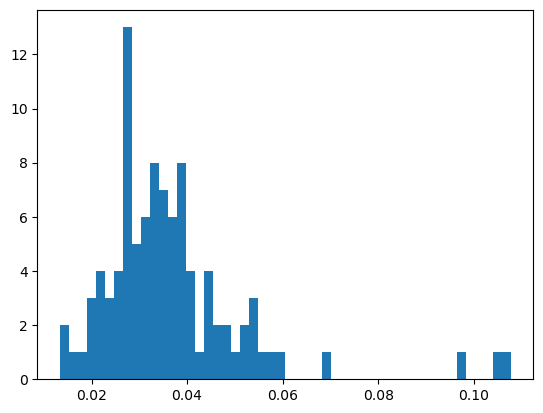

In [ ]:
hist = plt.hist(lambda_i, bins=50)

In [ ]:
df_lens

,xA,xB,beta,kappaA,kappaB,gammaA,gammaB,magnificationA,magnificationB,kappa_starA,...,logM_star,logM_star_sps,logM_star_sps_observed,logM_halo,logRe,zl,zs,lens_id,ycaustic_kpc,ycaustic_arcsec
0,4.803552,-3.025157,0.317519,0.352525,0.613251,0.444569,0.710522,4.506019,2.825768,0.223179,...,11.483519,11.383519,11.464911,12.930561,0.905065,0.3,2.0,2,3.075483,0.690451
1,6.719080,-0.822161,0.989704,0.240077,2.672946,0.307109,2.042436,2.069160,0.758034,0.123693,...,11.483519,11.383519,11.640435,12.930561,0.905065,0.3,2.0,2,3.075483,0.690451
2,5.866830,-1.947981,0.692570,0.279570,1.035791,0.357633,1.059986,2.555563,0.894995,0.157955,...,11.483519,11.383519,11.426480,12.930561,0.905065,0.3,2.0,2,3.075483,0.690451
3,5.347586,-2.481042,0.510018,0.310992,0.778049,0.395999,0.855612,3.143044,1.469856,0.185797,...,11.483519,11.383519,11.406921,12.930561,0.905065,0.3,2.0,2,3.075483,0.690451
4,5.243220,-2.586015,0.473186,0.318189,0.740428,0.404581,0.823651,3.317381,1.642485,0.192232,...,11.483519,11.383519,11.483152,12.930561,0.905065,0.3,2.0,2,3.075483,0.690451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,8.889674,-1.029698,0.871138,0.131701,2.743258,0.254771,3.561503,1.451201,0.104228,0.041531,...,11.325791,11.225791,11.348637,12.826235,0.503126,0.3,2.0,3,6.261840,1.405794
603,5.708517,-3.223865,0.271389,0.222106,0.506098,0.480433,1.021762,2.670030,1.252245,0.117392,...,11.325791,11.225791,11.365111,12.826235,0.503126,0.3,2.0,3,6.261840,1.405794
604,9.332252,-0.739192,0.950104,0.125376,4.261762,0.237202,4.800654,1.410948,0.081474,0.036793,...,11.325791,11.225791,11.172046,12.826235,0.503126,0.3,2.0,3,6.261840,1.405794
605,7.738945,-1.743583,0.661641,0.152919,1.288118,0.311852,2.090573,1.611932,0.233806,0.058212,...,11.325791,11.225791,11.186475,12.826235,0.503126,0.3,2.0,3,6.261840,1.405794


In [ ]:
mock_lens_data

,xA,xB,beta,kappaA,kappaB,gammaA,gammaB,magnificationA,magnificationB,kappa_starA,...,logM_star,logM_star_sps,logM_star_sps_observed,logM_halo,logRe,zl,zs,lens_id,ycaustic_kpc,ycaustic_arcsec
1,5.512813,-3.322377,0.356043,0.473377,0.715942,0.354069,0.573749,6.557057,4.063584,0.149455,...,11.415106,11.315106,11.245063,13.533639,0.917097,0.3,2.0,2,2.683582,0.602469
2,6.097398,-2.712408,0.547845,0.438984,0.856656,0.320524,0.688526,4.708016,2.226275,0.125227,...,11.415106,11.315106,11.395033,13.533639,0.917097,0.3,2.0,2,2.683582,0.602469
5,5.354323,-3.484879,0.304087,0.484042,0.687001,0.364361,0.549079,7.460222,4.964705,0.157175,...,11.415106,11.315106,11.376612,13.533639,0.917097,0.3,2.0,2,2.683582,0.602469
6,7.136547,-1.504607,0.889104,0.392070,1.476521,0.274053,1.119529,3.393014,0.996616,0.094151,...,11.415106,11.315106,11.358325,13.533639,0.917097,0.3,2.0,2,2.683582,0.602469
9,4.529655,-4.318916,0.034339,0.552107,0.573858,0.428681,0.448725,56.147389,53.646742,0.208337,...,11.415106,11.315106,11.469732,13.533639,0.917097,0.3,2.0,2,2.683582,0.602469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838967,5.189346,-2.807391,0.322923,0.192750,0.537517,0.487764,1.053636,2.416341,1.116767,0.149331,...,11.330343,11.230343,11.248391,12.191923,0.580530,0.3,2.0,9997,5.135924,1.153024
838969,5.740046,-2.351742,0.459989,0.162930,0.715021,0.425586,1.290093,1.924403,0.632231,0.120850,...,11.330343,11.230343,11.172740,12.191923,0.580530,0.3,2.0,9997,5.135924,1.153024
838972,5.488738,-2.556097,0.397869,0.175514,0.625754,0.452294,1.174146,2.103934,0.808107,0.132839,...,11.330343,11.230343,11.189037,12.191923,0.580530,0.3,2.0,9997,5.135924,1.153024
838993,6.250117,-1.953336,0.584072,0.141610,0.956224,0.378518,1.580282,1.684587,0.401148,0.100659,...,11.330343,11.230343,11.300481,12.191923,0.580530,0.3,2.0,9997,5.135924,1.153024


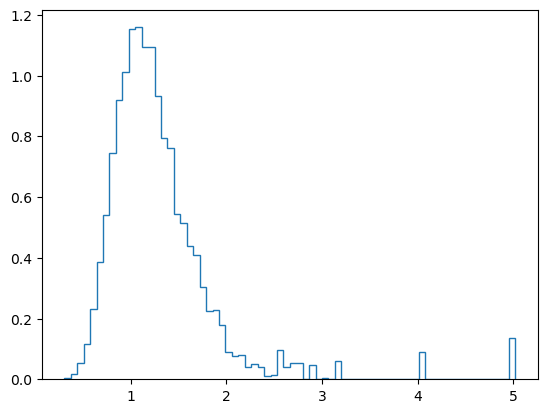

In [ ]:
ycaustic_arcsec = mock_lens_data["ycaustic_arcsec"]
hist = plt.hist(ycaustic_arcsec, bins=70, histtype="step", density=True)

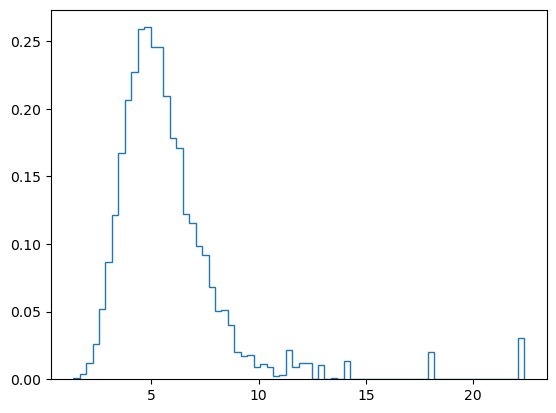

In [ ]:
ycaustic_kpc = mock_lens_data["ycaustic_kpc"]
hist = plt.hist(ycaustic_kpc, bins=70, histtype="step", density=True)

In [ ]:
3.14 * 10**2 * 4e-4

0.12560000000000002

In [ ]:
run_mock_simulation?

Signature:
run_mock_simulation(
    n_samples,
    maximum_magnitude=26.5,
    zl=0.3,
    zs=2.0,
    if_source=False,
    process=None,
    alpha_s=-1.3,
    m_s_star=24.5,
    logalpha: float = 0.1,
    seed=None,
    nbkg: float = 1.0,
    *,
    cache_every: int | None = None,
    cache_dir: str | pathlib.Path | None = None,
)
Docstring:
Run a mock strong-lens simulation.

Parameters
----------
n_samples : int
    Number of lens galaxies to simulate.
nbkg : float, optional
    Surface density of background sources in ``kpc^-2``.
File:      ~/Github/sl_inference_1Dinfer_hdf5_fix_A_runonlinux/mock_generator/mock_generator.py
Type:      function